# Lagged AR(1) Time Series Example
This notebook demonstrates cross-correlation and bootstrapped significance for two AR(1) time series where one is a lagged version of the other.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PhaseScrambledCorrelations import *

### 1. Generate AR(1) time series with a known lag relationship

In [2]:
N = 312
dt = 1.0
lag_true = 36  # true lag in time steps
rho = 0.9
noise_std = 1.0

# Generate base AR(1) process
ts_base = AR1_process(rho, noise_std, 1, N + lag_true, seed=123, dt=dt)

# Create lagged version
ts1 = TimeSeries(ts_base.time[:N], ts_base.data[:N], dt)
ts2 = TimeSeries(ts_base.time[:N], ts_base.data[lag_true:N+lag_true], dt)

ccf_maxlag = 100
ccf_ds = cross_correlation(ts1, ts2, maxlags=ccf_maxlag)
lag_max, ccf_max = cross_correlation_maxima(ts1, ts2, maxlags=ccf_maxlag)

### 2. Visualize the lagged AR(1) time series and their cross-correlation

/var/folders/xc/1pgd3mgn7qjdv8bmcggt31j40000gn/T/ipykernel_1199/324736295.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[1].legend()


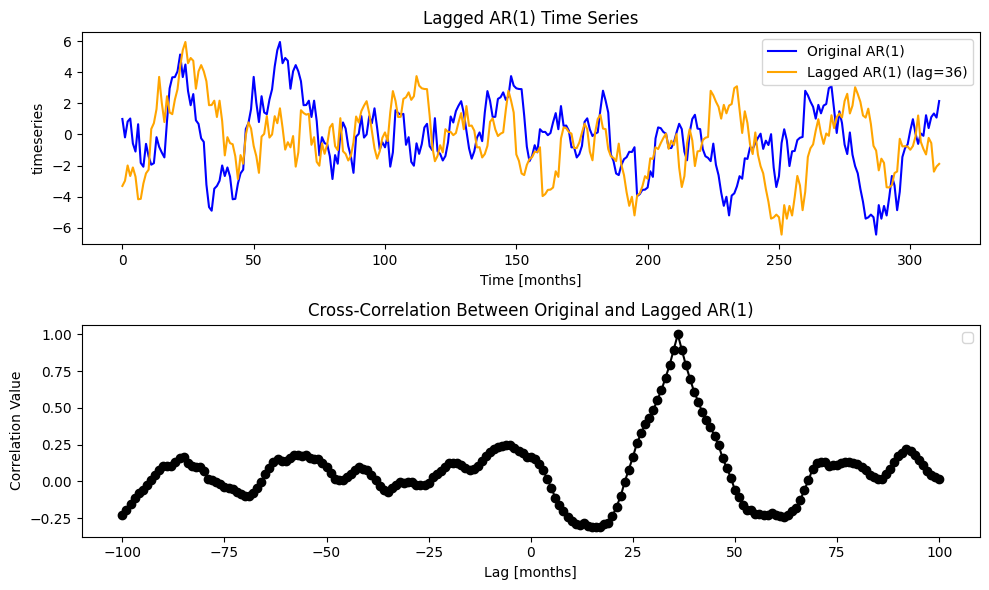

In [3]:
fig, axes = plt.subplots(2, 1, figsize=(10, 6))
ts1.da.plot(ax=axes[0], label='Original AR(1)', color='blue')
ts2.da.plot(ax=axes[0], label=f'Lagged AR(1) (lag={lag_true})', color='orange')
axes[0].set_title('Lagged AR(1) Time Series')
axes[0].set_xlabel('Time [months]')
axes[0].legend()

ccf_ds["cross_correlation"].plot(ax=axes[1], color='k', marker='o', zorder=1)
axes[1].set_title('Cross-Correlation Between Original and Lagged AR(1)')
axes[1].set_xlabel('Lag [months]')
axes[1].set_ylabel('Correlation Value')
axes[1].legend()
fig.tight_layout()

### 3. Check correlation significance using Gaussian and bootstrapped methods

In [ ]:
def plot_significant_correlations(ax, lags, ccf, pvals, alpha=0.05):
    colors = ['r' if p < alpha else 'k' for p in pvals]
    ax.plot(lags, ccf, c="k", zorder=0)
    ax.scatter(lags, ccf, c=colors, marker='o', zorder=2)
    ax.set_xlabel('Lag')
    ax.set_ylabel('Correlation Coefficient')
    ax.set_title(f'Significance (alpha={alpha})')
    ax.legend(handles=[
        plt.Line2D([0], [0], marker='o', color='w', label='Significant', markerfacecolor='r', markersize=8),
        plt.Line2D([0], [0], marker='o', color='w', label='Not Significant', markerfacecolor='k', markersize=8)
    ], loc='best')
    return ax

In [7]:
n_iter = 2500
bccf_ds = bootstrapped_cross_correlation(ts1, ts2, maxlags=ccf_maxlag, n_iter=n_iter, return_distributions=True, detrend=True)

Bootstrapping lags: 100%|██████████| 201/201 [00:15<00:00, 12.76it/s]


[None, None]

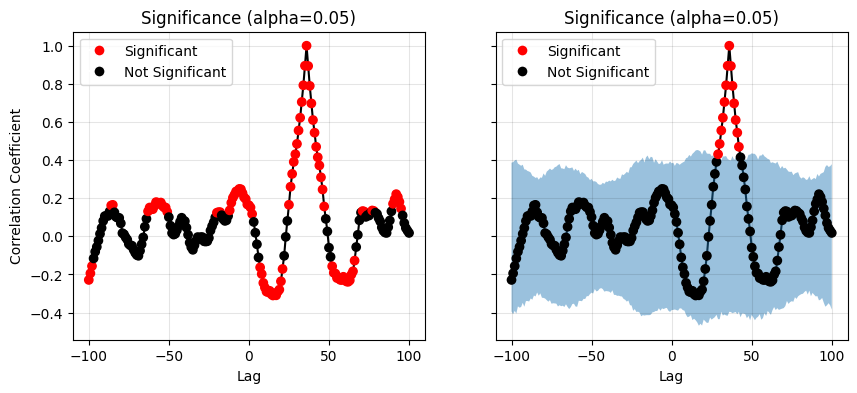

In [8]:
#### GAUSSIAN CCF SIGNIFICANCE #####
ccf_ds = cross_correlation(ts1, ts2, maxlags=ccf_maxlag)

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey = True)

axes[0].set_title("Cross Correlation Significance using Gaussian Assumption")
plot_significant_correlations(axes[0], ccf_ds["lag"], ccf_ds["cross_correlation"], ccf_ds["cross_correlation_pvalue"], alpha=0.05)

axes[1].set_title("Cross Correlation Significance using Phase Scrambling")
lb = bccf_ds["bootstrapped_cross_correlation_distribution"].quantile(dim = "bootstrap_iter", q = 0.025)
ub = bccf_ds["bootstrapped_cross_correlation_distribution"].quantile(dim = "bootstrap_iter", q = 0.975)
axes[1].fill_between(ccf_ds["lag"], lb, ub, alpha = 0.45, label = "Bootstrapped 95% Confidence Limits")
plot_significant_correlations(axes[1], bccf_ds["lag"], bccf_ds["bootstrapped_cross_correlation"], bccf_ds["bootstrapped_cross_correlation_pvalue"], alpha=0.05)

axes[1].set_ylabel("")

[a.grid(zorder = 0, alpha = 0.1, c = "k") for a in axes]

#### The cross-correlation peak should be at the true lag value, and the bootstrap should confirm its significance.